In [1]:
# Loading required Libraries
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from collections import Counter
import plotly.express as px
import time
import os
import copy
import itertools
import glob
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch
import gc

torch.manual_seed(42)
np.random.seed(0)

# External Packages
!pip -q install --upgrade pip
!pip -q install torchsummary torch-lr-finder
from torchsummary import summary as model_arch
from torch_lr_finder import LRFinder

# TensorBoard Loadout
from tensorflow import summary
import datetime
%reload_ext tensorboard

plt.ion()   # interactive mode

# TASK 1: Loading Data 
* We used `google_drive_downloader` for load dataset to colab environment.
* Using `glob` & `Pillow`, we loaded all the images for modelling pipeline.
> Few images had an extra `alpha` channel, so for consitency we explicity converted images to **RBG** format.
* Using the collection of images, we created **Custom PyTorch Dataset** followed by **Data Loaders**


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

if os.path.exists('./data/animal_dataset_intermediate/')==False:
  gdd.download_file_from_google_drive(file_id='176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D',
                                      dest_path='./data/animal_dataset_intermediate.zip',
                                      unzip=True, showsize=True, overwrite = False)
  print('Removed Zip post working'.upper())
  os.path.exists('./data/animal_dataset_intermediate.zip')
else:
  print("Data already present")

Data already present


In [3]:
DATA_PATH = './data/animal_dataset_intermediate/train/'
print('Cleaning Folder Names')
for i in os.listdir(DATA_PATH):
  os.renames(DATA_PATH+i,DATA_PATH+i.split('_')[0])

Cleaning Folder Names


In [4]:
def GetImagesFromFolder(PATH,Class_Folder,ext):
    images = [Image.open(file).convert('RGB') for e in ext for file in glob.glob(PATH+Class_Folder+'/*.' + e)]
    print(f"Found {len(images)} in folder {Class_Folder}")
    np.random.shuffle(images)
    return images,np.array([Class_Folder for i in range(len(images))])

In [5]:
DATA_PATH = './data/animal_dataset_intermediate/train/'
FOLDERS = os.listdir(DATA_PATH)
ext = ['jpg','jpeg','png']
le = LabelEncoder().fit(FOLDERS)

In [6]:
ALL_IMAGES,ALL_LABELS = [],[]
images_population ={}

for Class_Folder in FOLDERS:
    IMAGES,LABELS = GetImagesFromFolder(DATA_PATH,Class_Folder,ext)
    images_population[Class_Folder] = LABELS.shape[0]
    ALL_IMAGES.extend(IMAGES)
    ALL_LABELS.extend(LABELS)

Found 1676 in folder scoiattolo
Found 1680 in folder mucca
Found 1901 in folder farfalla
Found 1638 in folder pecora
Found 1301 in folder elefante


In [7]:
df = pd.DataFrame.from_dict({'Name':[i.capitalize() for i in images_population.keys()],'#Images':[i for i in images_population.values()]})

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen','olive']
fig = px.pie(df,values='#Images',names='Name', hole=.3, width=600, height=600)
fig.update_traces(hoverinfo='label+percent',textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout( title={'text': 'Population of Various Classes','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

In [8]:
# For benchmarking we have make 3 stratified splits(Train-Test-Validation) of 80:10:10 respectively.
from sklearn.model_selection import train_test_split
TRAIN_IMAGES, X_val_test, TRAIN_LABELS, y_val_test = train_test_split(ALL_IMAGES, ALL_LABELS, test_size=0.20, random_state=42,stratify=ALL_LABELS)
VAL_IMAGES, TEST_IMAGES, VAL_LABELS, TEST_LABELS =  train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=42,stratify=y_val_test)

In [9]:
# Creating Custom PyTorch Dataset
class Animal_Dataset(Dataset):
    def __init__(self, ImageData, Target, transform=None):
        self.ImageData = ImageData
        self.Target = torch.LongTensor(le.transform(Target))
        self.transform = transform

    def __getitem__(self, index):
        x = self.ImageData[index]
        y = self.Target[index]
        if self.transform:
            x = Image.fromarray(np.uint8(np.array(self.ImageData[index])))
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.ImageData)

# TASK 2: Pre-processing

| Augmentation        	| Definition                                                              	|            Use           	|
|----------------------	|-------------------------------------------------------------------------	|:------------------------:	|
| ColorJitter          	| Randomly change the brightness, contrast and   saturation of an image.  	|      Color Variance      	|
| RandomRotation       	| Rotate the image by angle                                               	|    Positional Variance   	|
| Resize               	| Resize the input PIL Image to the given size.                           	|    Positional Variance   	|
| RandomResizedCrop    	| Crop the given PIL Image to random size and   aspect ratio.             	|     Data Compression     	|
| RandomVerticalFlip   	| Vertically flip the given PIL Image randomly                            	|    Positional Variance   	|
| RandomHorizontalFlip 	| Horizontally flip the given PIL Image   randomly                        	|    Positional Variance   	|
| ToTensor             	| Convert a PIL Image or numpy.ndarray to tensor                        	| PyTorch Internal Working 	|
| RandomErasing        	| Randomly selects a rectangle region in an   image and erases its pixels 	|  Generalize the learning 	|

In [10]:
#  Augmentation used for enriching dataset
transform = {'train':transforms.Compose([transforms.ColorJitter(),
                                         transforms.RandomRotation(30),
                                         transforms.Resize((230,230)),
                                         transforms.RandomResizedCrop(225),
                                        #  transforms.RandomVerticalFlip(),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.RandomErasing()
                                         ]),
             
             'val':transforms.Compose([transforms.Resize((225,225)),
                                      transforms.ToTensor()]),
             
             'test':transforms.Compose([transforms.Resize((225,225)),
                                      transforms.ToTensor()])}
# Used to see if GPU is available or not?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining Batch sizes for all the 3 splits
# Batch Size for Validation & Test data is higher to speed up prediction
batch_size = {'train':256, 'val':512,'test':512}

dataset_classes = ['farfalla', 'elefante', 'mucca', 'pecora', 'scoiattolo']

# Using custom dataset class to load Image Data as tensors.
image_datasets = {'train': Animal_Dataset(TRAIN_IMAGES, TRAIN_LABELS, transform=transform['train']),
                  'val':   Animal_Dataset(VAL_IMAGES, VAL_LABELS, transform=transform['val']),
                  'test':  Animal_Dataset(TEST_IMAGES, TEST_LABELS, transform=transform['test'])}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

# Creating Iterators for Dataset
dataloaders = {indx: DataLoader(image_datasets[indx], batch_size=batch_size[indx], num_workers=2, pin_memory=False, shuffle=True)
              for indx in batch_size.keys()}

print("Size for Dataset:\n\t* Train: %d\n\t* Valid: %d\n\t* Test: %d"%(dataset_sizes['train'],dataset_sizes['val'],dataset_sizes['test']))

Size for Dataset:
	* Train: 6556
	* Valid: 820
	* Test: 820


In [11]:
# Helper function to display the image
def imshow(img):
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

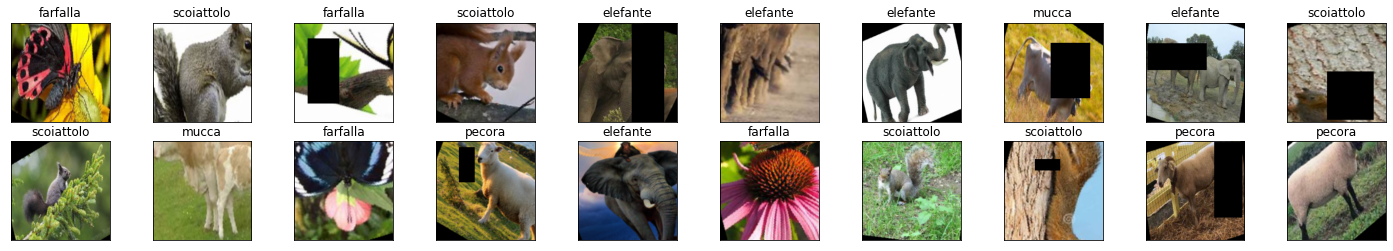

In [12]:
# Get one batch of training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

labels = le.inverse_transform([i.item() for i in labels])

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx])

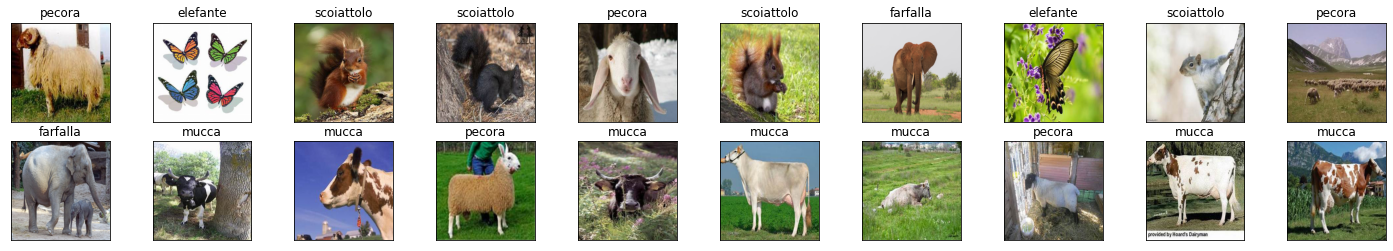

In [13]:
# Get one batch of validation images
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(dataset_classes[labels[idx]])

In [14]:
def train_model(model, criterion, optimizer, model_checkpoint=0, early_stop = 10, num_epochs=5):
  model = model.to(device)

  # number of epochs to train the model
  valid_loss_min = np.Inf # track change in validation loss
  early_stop_cnt = 0
  last_epoch_loss = np.Inf
  globaliter = 0

  final_loss = np.Inf

  for epoch in range(1, num_epochs+1):

      globaliter+=1
      # keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0

      
      ###################
      # train the model #
      ###################
      model.train()
      train_corrects = 0

      for data, target in dataloaders['train']:
          data, target = data.to(device), target.to(device)
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          _, preds = torch.max(output, 1)
          # calculate the batch loss
          loss = criterion(output, target)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update training loss
          train_loss += loss.item()*data.size(0)
          train_corrects += torch.sum(preds == target.data)
      
      train_loss = train_loss/len(dataloaders['train'].dataset)
      train_acc = (train_corrects.double()*100)/len(dataloaders['train'].dataset)
      with train_summary_writer.as_default():
          summary.scalar('loss', train_loss, step=epoch)
          summary.scalar('accuracy', train_acc.item(), step=epoch)
          
      ######################    
      # validate the model #
      ######################
      model.eval()
      val_corrects = 0
      for data, target in dataloaders['val']:
          data, target = data.to(device), target.to(device)
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          _, preds = torch.max(output, 1)
          # calculate the batch loss
          loss = criterion(output, target)
          # update average validation loss
          valid_loss += loss.item()*data.size(0)
          val_corrects += torch.sum(preds == target.data)
      
      # calculate average losses
      valid_loss = valid_loss/len(dataloaders['val'].dataset)
      valid_acc = (val_corrects.double()*100)/len(dataloaders['val'].dataset)
      with test_summary_writer.as_default():
          summary.scalar('loss', valid_loss, step=epoch)
          summary.scalar('accuracy', valid_acc.item(), step=epoch)
          
      # print training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
      print('\t\tTraining Acc:  {:.3f} \t\tValidation Acc:{:.3f}'.format(train_acc, valid_acc))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).'.format(valid_loss_min,valid_loss))
          if model_checkpoint != 0:
            torch.save(model.state_dict(), 'model.pt'.format(train_acc, valid_acc))
            print('Model Saved: model.pt'.format(train_acc, valid_acc))
          valid_loss_min = valid_loss
      elif valid_loss == np.nan:
        print("Model Loss: NAN")

      if (last_epoch_loss < valid_loss) and last_epoch_loss != np.Inf:
        early_stop_cnt +=1
        if early_stop_cnt == early_stop:
          print('-'*50+"\nEarly Stopping Hit\n"+'-'*50)
          break
        else:
          print('-'*50+f"\n\t\tEarly Stopping Step: {early_stop_cnt}/{early_stop}\n"+'-'*50)
      else:
        early_stop_cnt = 0
        last_epoch_loss = valid_loss

  print(f"Training Completed with best model having loss of {valid_loss_min}")
  del data,target
  gc.collect()
  return model


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    size = len(classes)*2
    plt.figure(figsize = (size,size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)

    
def model_verification(loader,batch_size,model,n_classes=5):
    classes = list(le.inverse_transform([i for i in range(n_classes)]))
    prediction_list,label_list = [],[]
    with torch.no_grad():
        for images, labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          predicted = outputs.argmax(dim=1).detach()
          prediction_list.extend(predicted.tolist())
          label_list.extend(labels.tolist())
    cm = confusion_matrix(prediction_list,label_list)
    plot_confusion_matrix(cm, classes)
    if device.type == 'cuda':
      images = images.cpu()
      labels = labels.cpu()
    gc.collect()


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (num_images,num_images))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {dataset_classes[preds[j]]} | Actual: {dataset_classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    if device.type == 'cuda':
      inputs = inputs.cpu()
      labels = labels.cpu()
    gc.collect()

# TASK 3: Building a Multi-Layer Perceptron
> In our model, we have 5 Dense layers each with a dropout layer for regularization.
* We have used ReLu activation function 


In [15]:
input_size = 3*225*225
output_size = 5


class Animal_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 1536)
    self.fc2 = nn.Linear(1536, 768)
    self.fc3 = nn.Linear(768, 384)
    self.fc4 = nn.Linear(384, 128)
    self.fc5 = nn.Linear(128, output_size)

  def forward(self, xb):
    # Flatten images into vectors
    out = xb.view(xb.size(0), -1)
    # Apply layers & activation functions
    out = self.fc1(out)
    out = F.relu(F.dropout(out))
    out = self.fc2(out)
    out = F.relu(F.dropout(out))
    out = self.fc3(out)
    out = F.relu(F.dropout(out))
    out = self.fc4(out)
    out = F.relu(F.dropout(out))
    out = self.fc5(out)
    return out

model_nn = Animal_NN().to(device)
model_nn

Animal_NN(
  (fc1): Linear(in_features=151875, out_features=1536, bias=True)
  (fc2): Linear(in_features=1536, out_features=768, bias=True)
  (fc3): Linear(in_features=768, out_features=384, bias=True)
  (fc4): Linear(in_features=384, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=5, bias=True)
)

# TASK 4: Optimizer
> * For Optimizer, we are using `SGD` with learning rate 0.01
* For Loss Function, we are using `CrossEntropyLoss` due to multi-class classification.
* Metric for our case is accuracy, our loss function will penalize for wrong prediction.

In [16]:
# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
lr = 0.01
momentum = 0.9
decay = 0.0001
optimizer_ft = optim.SGD(model_nn.parameters(), lr=lr, momentum = momentum, weight_decay = decay)

# TASK 5: Training the model
> * Fit the model to the data by dividing the train data into train and validation set in a ratio of 80:20. 
* Decide the number of epochs and ensure overfitting doesn’t occur.
* For Regularization, we are using 

>> *   Early Stop: Help loss from deviating
>> *   Drop-Out layer: Generalizes model learning thoughout, and not selectively relying on certain neuron output 



In [17]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/ann/train/' + current_time
test_log_dir = 'logs/tensorboard/ann/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [18]:
print('\nTraining of Model:')
model_nn = train_model(model_nn, criterion, optimizer_ft, num_epochs = 50, model_checkpoint = 1)


Training of Model:
Epoch: 1 	Training Loss: 1.611771 	Validation Loss: 1.620606
		Training Acc:  21.599 		Validation Acc:21.463
		Validation loss decreased (inf --> 1.620606).
Model Saved: model.pt
Epoch: 2 	Training Loss: 1.611608 	Validation Loss: 1.608642
		Training Acc:  21.126 		Validation Acc:21.951
		Validation loss decreased (1.620606 --> 1.608642).
Model Saved: model.pt
Epoch: 3 	Training Loss: 1.606341 	Validation Loss: 1.607712
		Training Acc:  22.788 		Validation Acc:22.805
		Validation loss decreased (1.608642 --> 1.607712).
Model Saved: model.pt
Epoch: 4 	Training Loss: 1.604441 	Validation Loss: 1.605759
		Training Acc:  22.819 		Validation Acc:22.317
		Validation loss decreased (1.607712 --> 1.605759).
Model Saved: model.pt
Epoch: 5 	Training Loss: 1.602398 	Validation Loss: 1.606092
		Training Acc:  23.261 		Validation Acc:20.732
--------------------------------------------------
		Early Stopping Step: 1/10
--------------------------------------------------
Epoch: 6 	

In [19]:
os.rename('model.pt','model_ann.pt')

# TASK 6: Tensorboard
> Using Tensorboard to display the accuracy and loss graphs of the training. 


In [20]:
%tensorboard --logdir logs/tensorboard/ann/

Reusing TensorBoard on port 6006 (pid 1027), started 1:16:06 ago. (Use '!kill 1027' to kill it.)

<IPython.core.display.Javascript object>

Confusion matrix, without normalization
[[10  1  3  6  7]
 [10 98 12 17 31]
 [55 26 84 56 31]
 [10 22 35 58 27]
 [45 44 34 27 71]]


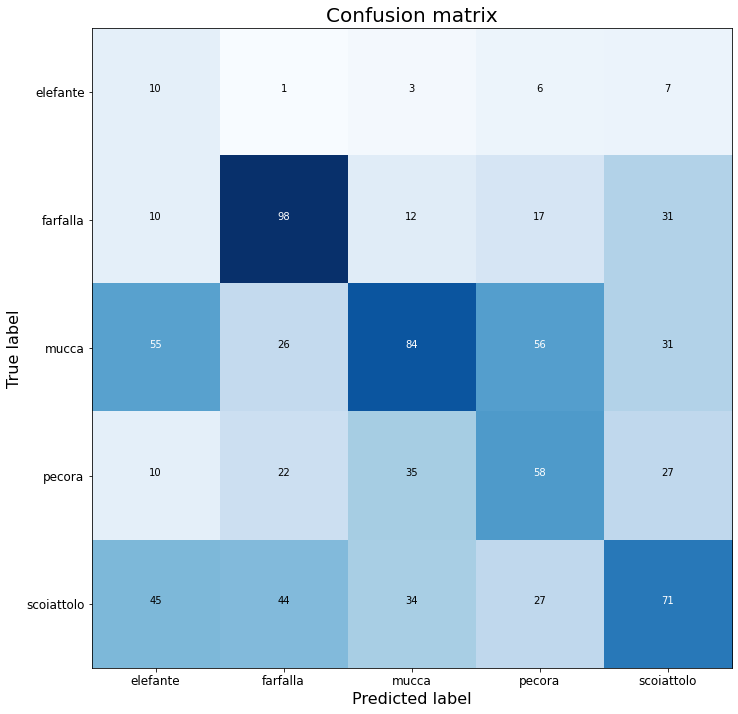

In [21]:
model_verification(dataloaders['test'],batch_size['test'],model_nn,n_classes=5)

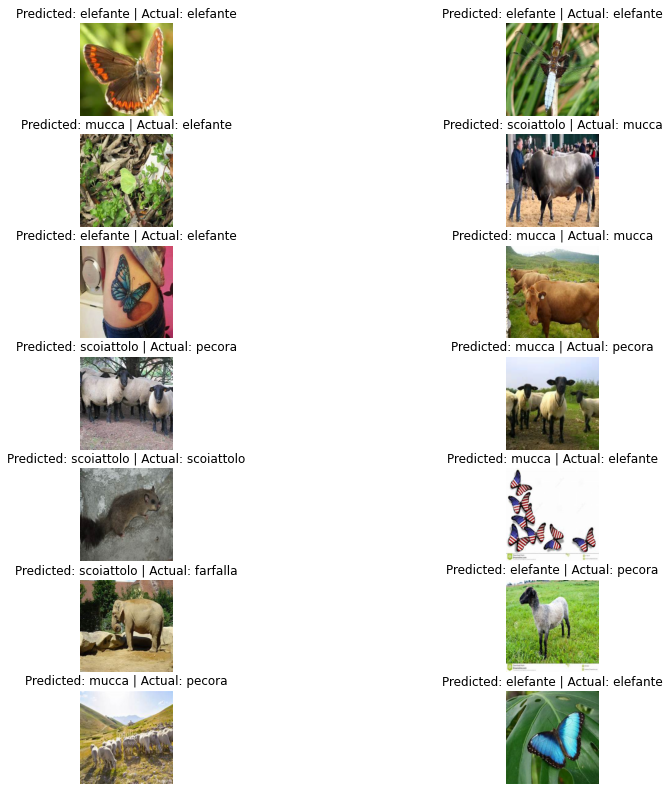

In [22]:
visualize_model(model_nn, num_images=14)

# TASK 7: Building a Convolutional Neural Network
* In this we will be using `Transfer Learning`
* We will make use of `DenseNet161` (as feature extractor)
* We will train only the `Classification` layers
* For Optimizer, we are using `SGD` with learning rate 0.01
* For Loss Function, we are using `CrossEntropyLoss` due to multi-class classification 


In [23]:
gc.collect()
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/cnn/train/' + current_time
test_log_dir = 'logs/tensorboard/cnn/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

In [24]:
n_classes = len(dataset_classes)

model_ft = models.densenet161(pretrained=True)
# Using Model as Feature Extractor
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier.in_features
# model_ft.classifier = nn.Linear(num_ftrs, n_classes)
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, int(num_ftrs/2)), nn.Dropout(), nn.Linear(int(num_ftrs/2), n_classes))
model_ft = model_ft.to(device)

model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
# Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# SGD Optimizer
lr = 0.01
momentum = 0.5
decay = 0.0001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum = momentum, weight_decay = decay)

In [26]:
print('\nTraining of Model:')
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs = 50, model_checkpoint = 1)


Training of Model:
Epoch: 1 	Training Loss: 1.133392 	Validation Loss: 0.610399
		Training Acc:  67.114 		Validation Acc:94.756
		Validation loss decreased (inf --> 0.610399).
Model Saved: model.pt
Epoch: 2 	Training Loss: 0.610446 	Validation Loss: 0.327109
		Training Acc:  87.782 		Validation Acc:96.585
		Validation loss decreased (0.610399 --> 0.327109).
Model Saved: model.pt
Epoch: 3 	Training Loss: 0.437969 	Validation Loss: 0.230156
		Training Acc:  89.811 		Validation Acc:96.220
		Validation loss decreased (0.327109 --> 0.230156).
Model Saved: model.pt
Epoch: 4 	Training Loss: 0.360660 	Validation Loss: 0.192137
		Training Acc:  90.985 		Validation Acc:95.976
		Validation loss decreased (0.230156 --> 0.192137).
Model Saved: model.pt
Epoch: 5 	Training Loss: 0.331938 	Validation Loss: 0.165116
		Training Acc:  90.635 		Validation Acc:96.463
		Validation loss decreased (0.192137 --> 0.165116).
Model Saved: model.pt
Epoch: 6 	Training Loss: 0.308979 	Validation Loss: 0.154982
		Tr

In [27]:
os.rename('model.pt','model_cnn.pt')

In [28]:
%tensorboard --logdir logs/tensorboard/cnn/

Reusing TensorBoard on port 6007 (pid 2290), started 1:16:11 ago. (Use '!kill 2290' to kill it.)

<IPython.core.display.Javascript object>

Confusion matrix, without normalization
[[129   1   1   1   0]
 [  0 190   1   0   3]
 [  0   0 159   6   1]
 [  1   0   7 157   1]
 [  0   0   0   0 162]]


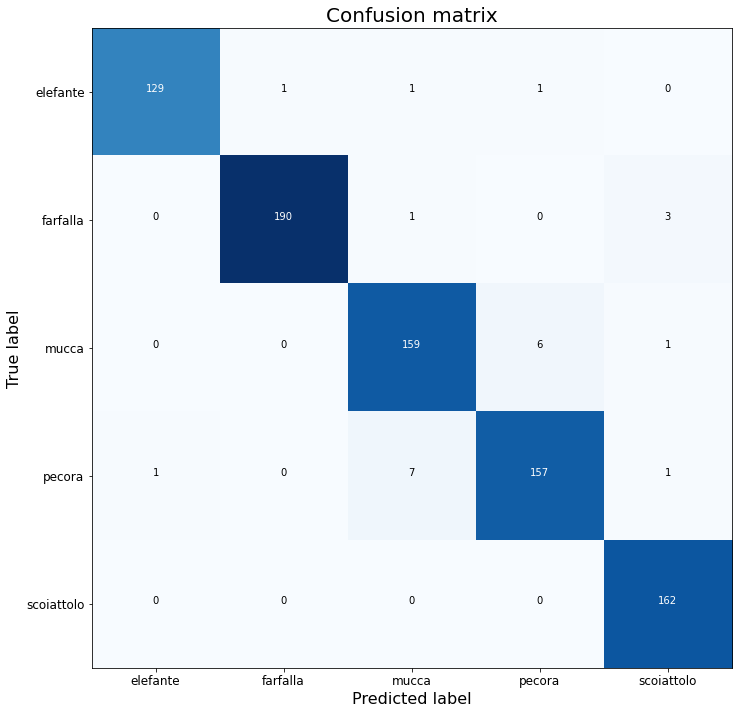

In [29]:
model_verification(dataloaders['test'],batch_size['test'],model_ft,n_classes=5)

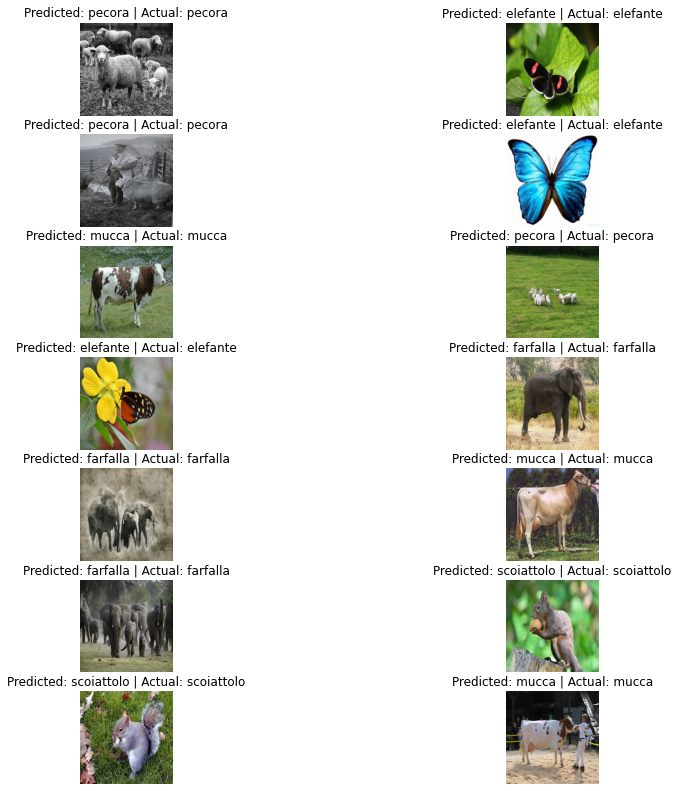

In [30]:
visualize_model(model_ft, num_images=14)

In [31]:
gc.collect()

28489

# Loading Data for Prediciton

In [32]:
# Creating Custom Dataset to read images in the order as mentioned in CSV file.
class Dphi_Dataset(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.BASE_DIR = './data/animal_dataset_intermediate/test/'
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image = Image.open(self.BASE_DIR+self.data.filename.iloc[index]).convert('RGB')
        label = 0
        if self.transform is not None:
            image = self.transform(image)        
        return image, label

In [37]:
CSV_PATH = './data/animal_dataset_intermediate/Testing_set_animals.csv'

test_transform = transforms.Compose([transforms.Resize((225,225)), transforms.ToTensor()])
batch_size = 60

test_data = Dphi_Dataset(CSV_PATH, transform=test_transform)
test_loaders = DataLoader(test_data, batch_size=batch_size, num_workers=2, shuffle=False)

print("Size for Test Dataset: %d"%(len(test_data)))

Size for Test Dataset: 910


# Visualizing few images from Test

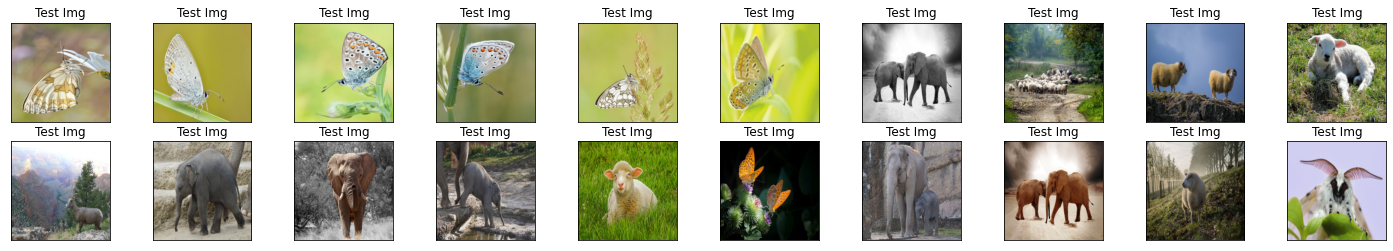

In [38]:
# Get one batch of training images
dataiter = iter(test_loaders)
images, labels = dataiter.next()
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title('Test Img')

In [39]:
gc.collect()

30020

# TASK 9: Predict
> We have saved out model weights on disk. We will be using that for prediction.

In [ ]:
model = models.densenet161(pretrained=False)
num_ftrs = model.classifier.in_features
# model_ft.classifier = nn.Linear(num_ftrs, n_classes)
model.classifier = nn.Sequential(nn.Linear(num_ftrs, int(num_ftrs/2)), nn.Dropout(), nn.Linear(int(num_ftrs/2), n_classes))
model = model

PATH = 'model_cnn.pt'
model.load_state_dict(torch.load(PATH))

RESULT_FILE_NAME = f"Prediction_{PATH}.csv"
all_preds = list()
model.eval()
for data, _ in dataloaders['test']:
    data = data
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    _, preds = torch.max(output, 1)
    all_preds.extend(preds.tolist())

results = all_preds
# results = le.inverse_transform(all_preds)
np.savetxt(RESULT_FILE_NAME, results, fmt='%s',delimiter=",")
print(f"Shape of Results: {results.shape}\n File created: {RESULT_FILE_NAME}")